In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import string
import multiprocessing as mp

In [2]:
seed = 280
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [3]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)

ID:  LX6WJTT1_08_30_56


In [4]:
C_POS_MAX =  5
C_POS_MIN = -5

C_VEL_MAX =  5
C_VEL_MIN = -5

P_ANG_MAX =  1
P_ANG_MIN = -1

P_VEL_MAX =  5
P_VEL_MIN = -5

In [5]:
GRANULARITY = 50
print("GRANULARITY: ", GRANULARITY)

GRANULARITY:  50


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
Q_TABLE = np.zeros((GRANULARITY,
                    GRANULARITY,
                    GRANULARITY,
                    GRANULARITY, 
                    N_ACTIONS))

c_pos_s = np.linspace(C_POS_MIN, C_POS_MAX, GRANULARITY)
c_vel_s = np.linspace(C_VEL_MIN, C_VEL_MAX, GRANULARITY)
p_ang_s = np.linspace(P_ANG_MIN, P_ANG_MAX, GRANULARITY)
p_vel_s = np.linspace(P_VEL_MIN, P_VEL_MAX, GRANULARITY)

Q_FILENAME = RNDM_STRING + "_Q_TABLE"+".qpy"
np.save(Q_FILENAME, Q_TABLE)
# print("Q-TABLE FILENAME: ", Q_FILENAME,".qpy")

In [8]:
state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                GRANULARITY)

In [9]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [10]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 200
NO_OF_EPISODES = 5
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  200
Number of EPISODES per NODE 5


In [11]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 20000

In [12]:
MAX_NO_OF_ITERATIONS = 25
MAX_NN_ITERATIONS    = 3000

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [14]:
class DDQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [15]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [16]:
def mp_node_run(node_id):
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195
    
    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR
    my_FILE      = Q_FILENAME + ".npy"
    while True:
        i_episode = 0
        new_Q_TABLE = np.load(my_FILE)
        my_Q_TABLE  = np.load(my_FILE)


        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

            s = my_env.reset()
            while True:
                [c_pos_state, 
                c_vel_state, 
                p_ang_state, 
                p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                         c_pos_s, 
                                         c_vel_s, 
                                         p_ang_s, 
                                         p_vel_s)
                time_steps += 1
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1

                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                [next_c_pos_state, 
                next_c_vel_state, 
                next_p_ang_state, 
                next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                              c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

                # learn
                this_state = tuple([c_pos_state, 
                              c_vel_state, 
                              p_ang_state, 
                              p_vel_state])

                next_state = tuple([ next_c_pos_state, 
                               next_c_vel_state, 
                               next_p_ang_state, 
                               next_p_vel_state])

                my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
                                                                         my_Q_TABLE[this_state][a])
                if done:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

#             #TO LEVEL UP    
#             if np.mean(time_rec[-10:]) > level_up_metric:
#                 PERFECT_RUN_COUNTER += 1
#             else:
#                 PERFECT_RUN_COUNTER = 0

#             if PERFECT_RUN_COUNTER > PERFECT_RUNS_HIGH_SCORE:
#                 PERFECT_RUN_COUNTER = 0
#                 PERFECT_RUNS_HIGH_SCORE *= 1.5
#                 my_LR *= 0.1
#                 if my_EPSILON < 0.99:
#                     my_EPSILON += 0.02
            
            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break
    
    exp_rec = np.delete(exp_rec, 0, 0)
#     message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#     print(message)
    return exp_rec, time_rec

NN-MODEL FILENAME:  LX6WJTT1_08_30_56_NN.xpt


ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 29
REAL TIME TO GENERATE 9565 EXPERIENCES:0:00:02.582891


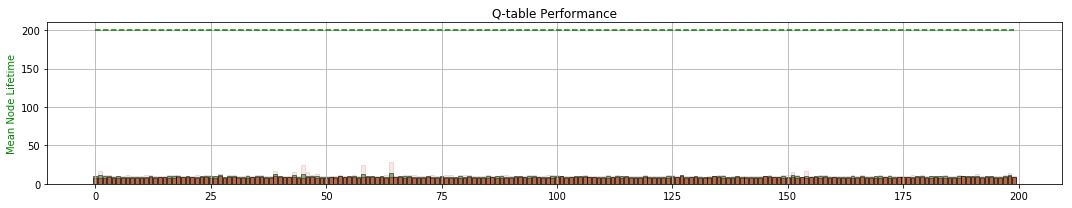

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  73.97
Validating... MEAN TIME:  71.71
Validating... MEAN TIME:  55.265
Validating... MEAN TIME:  92.615
Validating... MEAN TIME:  61.855
TRAINING TIME:0:00:22.400790


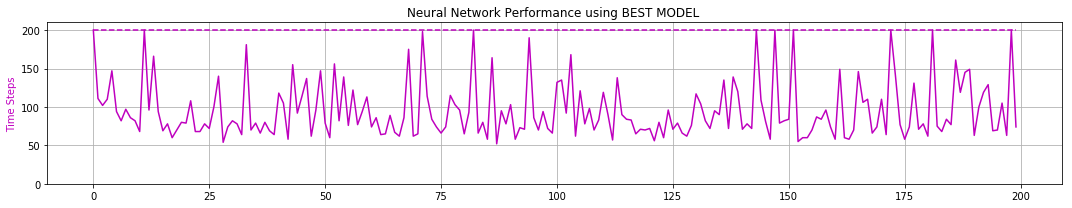

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 1
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 1: 148
REAL TIME TO GENERATE 68939 EXPERIENCES:0:00:02.041025


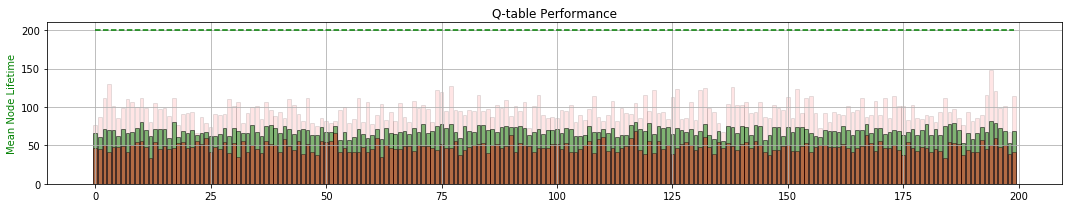

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  79.195
Validating... MEAN TIME:  74.585
Validating... MEAN TIME:  15.55
Validating... MEAN TIME:  9.495
Validating... MEAN TIME:  9.395
TRAINING TIME:0:00:13.111262


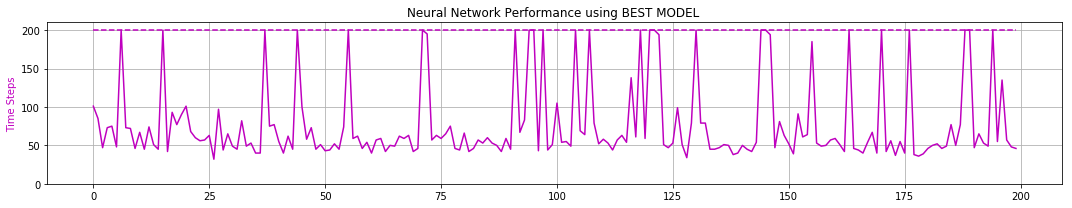

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 2
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 2: 200
REAL TIME TO GENERATE 88621 EXPERIENCES:0:00:02.293000


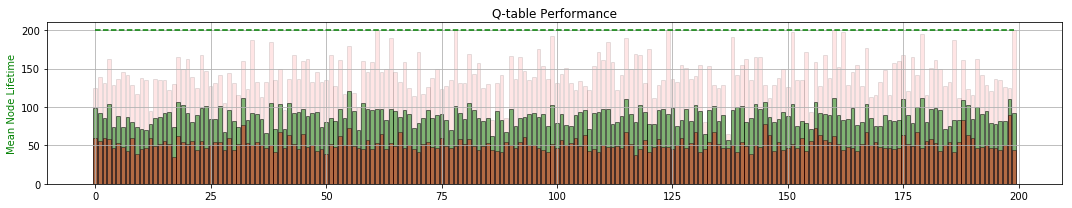

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.445
Validating... MEAN TIME:  48.69
Validating... MEAN TIME:  22.17
Validating... MEAN TIME:  20.26
Validating... MEAN TIME:  12.22
TRAINING TIME:0:00:10.205771


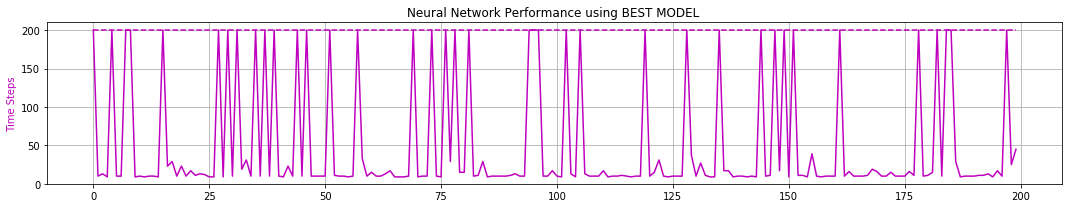

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 3
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 3: 200
REAL TIME TO GENERATE 30260 EXPERIENCES:0:00:01.682136


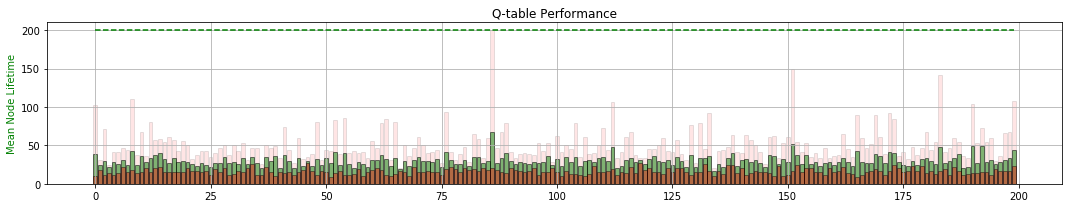

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.72
Validating... MEAN TIME:  127.64
Validating... MEAN TIME:  105.4
Validating... MEAN TIME:  113.41
Validating... MEAN TIME:  159.845
TRAINING TIME:0:00:33.364339


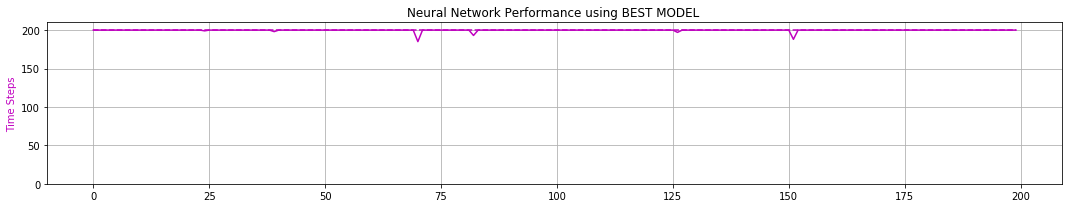

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 4
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 4: 153
REAL TIME TO GENERATE 118682 EXPERIENCES:0:00:02.668716


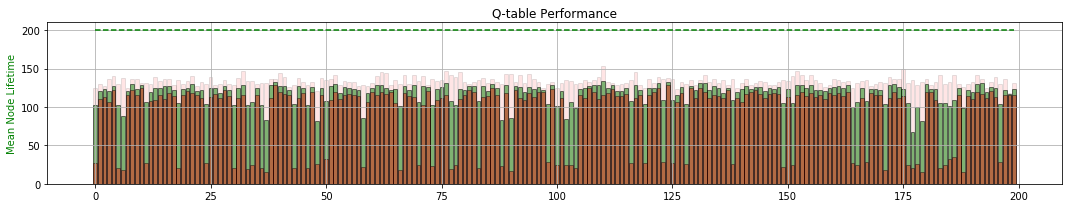

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.3
Validating... MEAN TIME:  9.435
Validating... MEAN TIME:  9.375
Validating... MEAN TIME:  9.365
Validating... MEAN TIME:  9.37
TRAINING TIME:0:00:05.638468


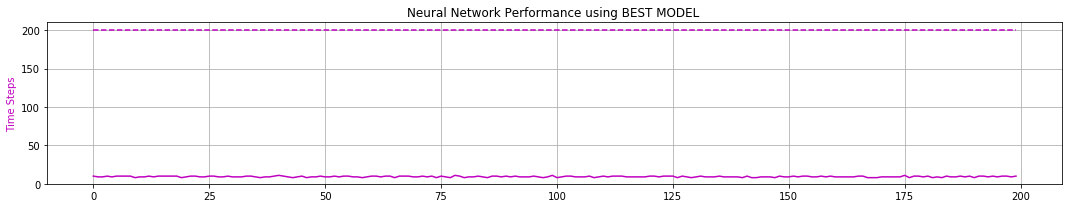

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 5
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 5: 15
REAL TIME TO GENERATE 9459 EXPERIENCES:0:00:01.356176


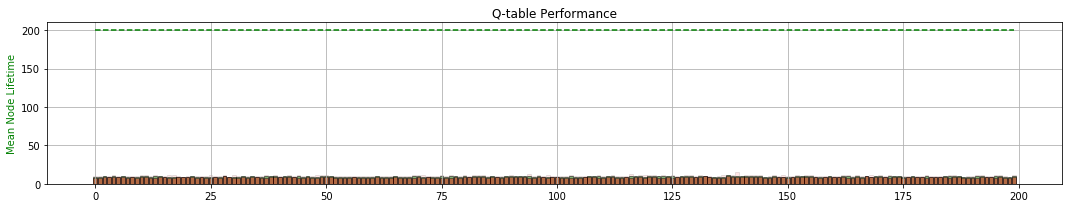

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.425
Validating... MEAN TIME:  9.565
Validating... MEAN TIME:  9.51
Validating... MEAN TIME:  10.025
Validating... MEAN TIME:  14.525
TRAINING TIME:0:00:05.974336


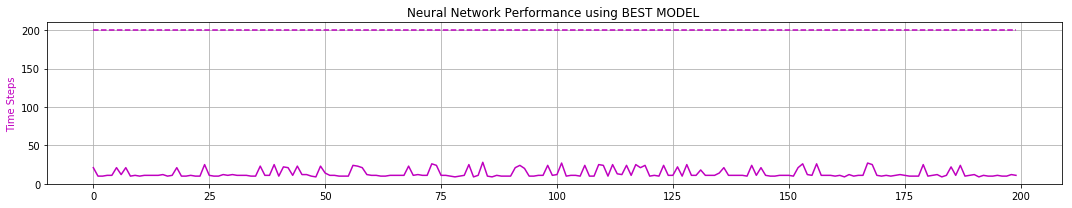

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 6
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 6: 14
REAL TIME TO GENERATE 9651 EXPERIENCES:0:00:01.365885


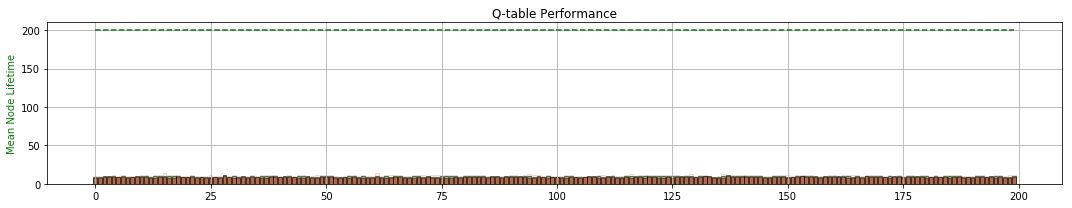

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  9.345
Validating... MEAN TIME:  9.285
Validating... MEAN TIME:  9.41
Validating... MEAN TIME:  9.26
Validating... MEAN TIME:  9.42
TRAINING TIME:0:00:05.642674


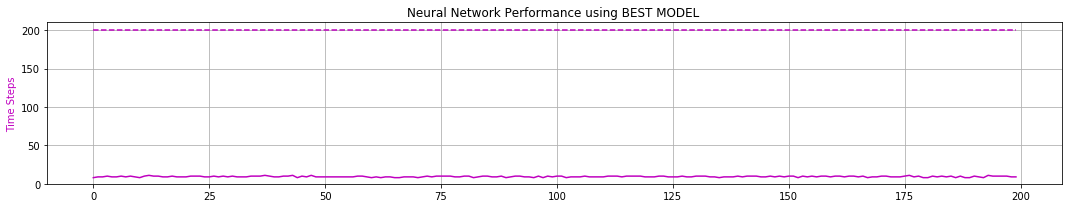

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 7
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 7: 14
REAL TIME TO GENERATE 9440 EXPERIENCES:0:00:01.322947


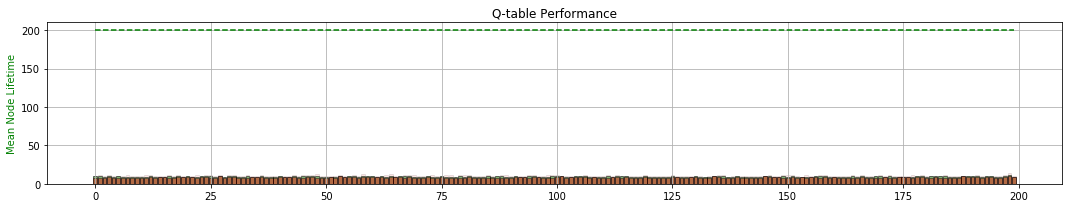

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  172.52
Validating... MEAN TIME:  139.52
Validating... MEAN TIME:  91.04
Validating... MEAN TIME:  37.0
Validating... MEAN TIME:  65.985
TRAINING TIME:0:00:26.863324


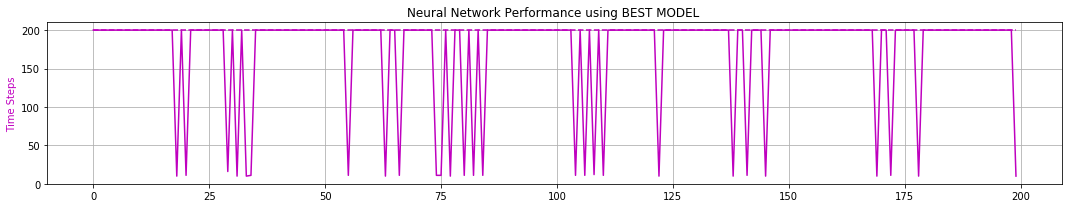

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 8
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 8: 200
REAL TIME TO GENERATE 56395 EXPERIENCES:0:00:01.856967


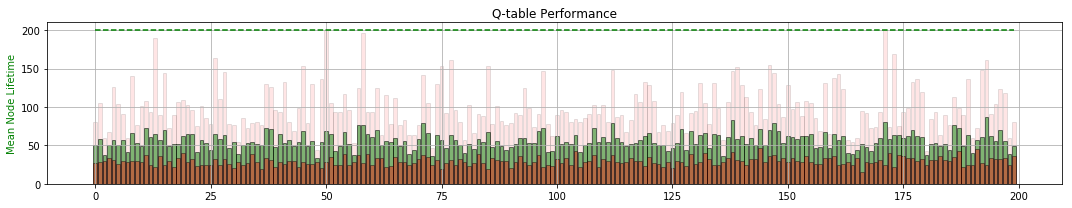

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.89
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:43.970413


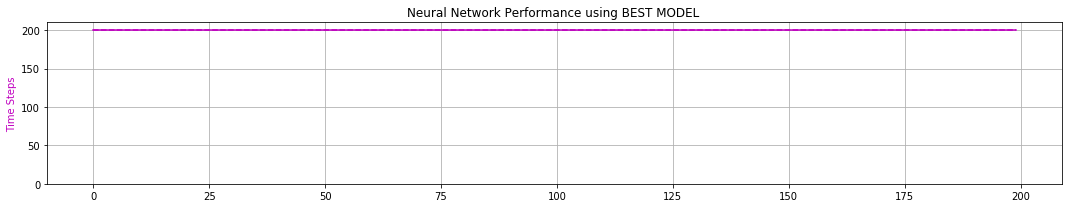

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 9
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 9: 200
REAL TIME TO GENERATE 194568 EXPERIENCES:0:00:03.627678


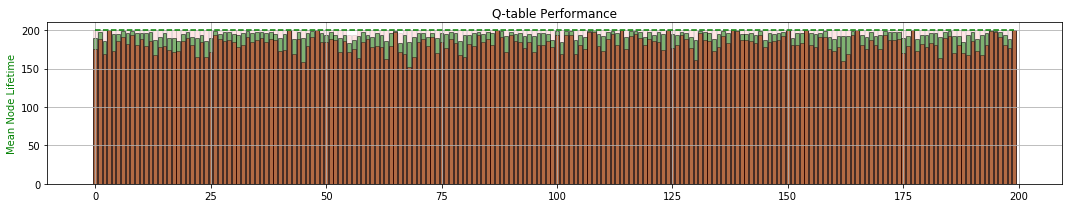

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.064324


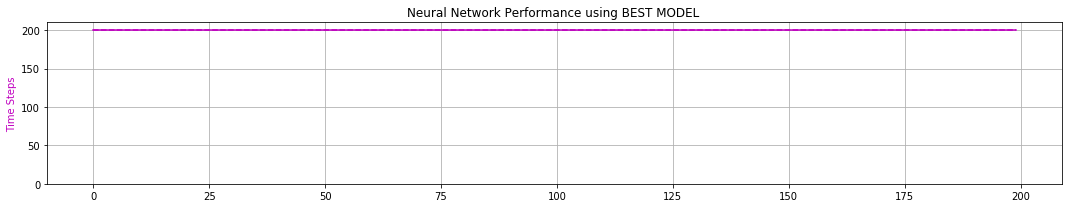

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 10
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 10: 200
REAL TIME TO GENERATE 179552 EXPERIENCES:0:00:03.448247


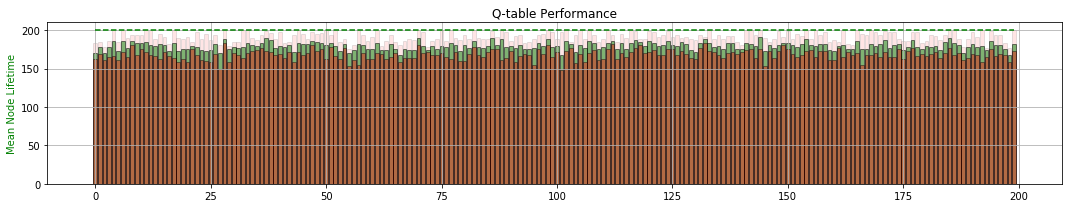

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  192.735
Validating... MEAN TIME:  199.7
Validating... MEAN TIME:  199.205
Validating... MEAN TIME:  192.17
Validating... MEAN TIME:  196.54
TRAINING TIME:0:00:48.365602


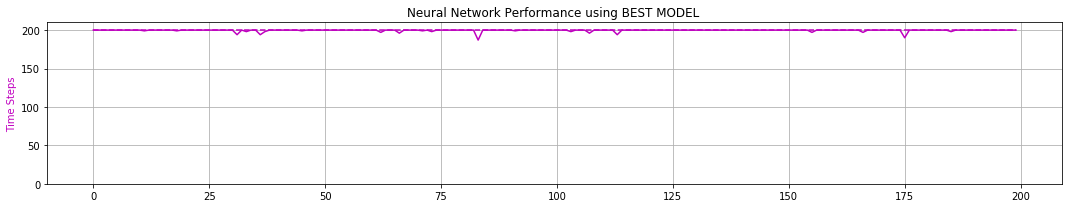

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 11
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 11: 185
REAL TIME TO GENERATE 159441 EXPERIENCES:0:00:03.179783


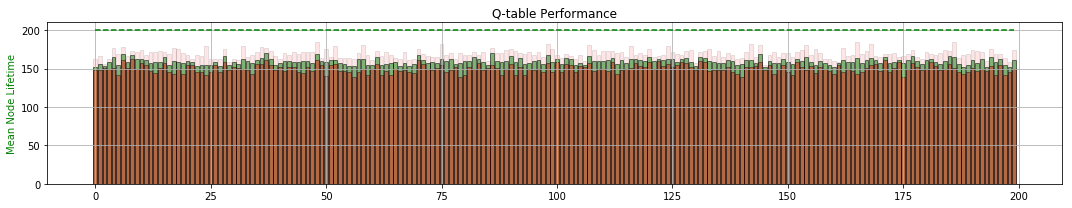

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  143.415
Validating... MEAN TIME:  145.915
Validating... MEAN TIME:  163.21
Validating... MEAN TIME:  162.67
Validating... MEAN TIME:  174.335
TRAINING TIME:0:00:37.484847


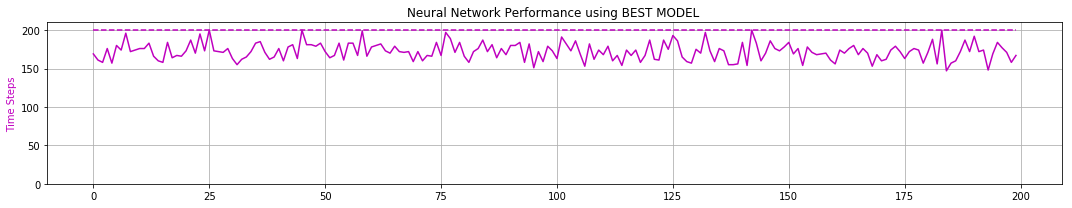

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 12
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 12: 186
REAL TIME TO GENERATE 131675 EXPERIENCES:0:00:02.955891


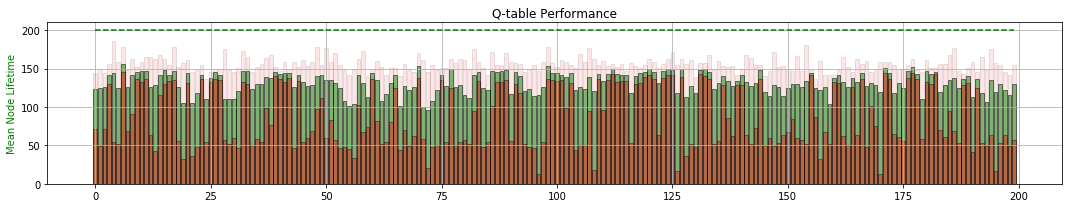

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  184.085
Validating... MEAN TIME:  178.395
Validating... MEAN TIME:  182.24
Validating... MEAN TIME:  155.565
Validating... MEAN TIME:  172.33
TRAINING TIME:0:00:43.723177


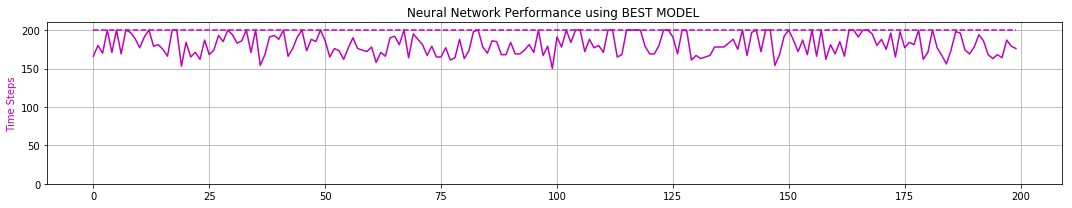

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 13
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 13: 195
REAL TIME TO GENERATE 145236 EXPERIENCES:0:00:02.957669


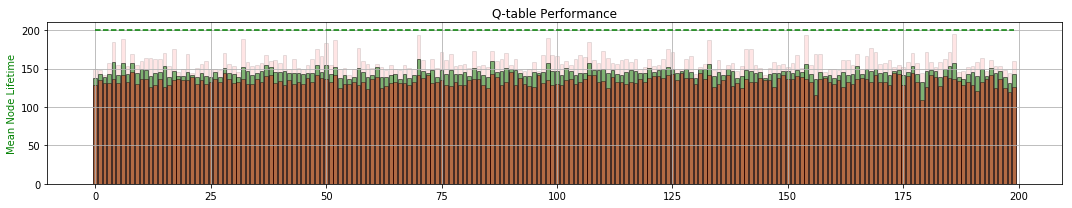

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  154.71
Validating... MEAN TIME:  146.975
Validating... MEAN TIME:  149.175
Validating... MEAN TIME:  155.735
Validating... MEAN TIME:  153.98
TRAINING TIME:0:00:34.070672


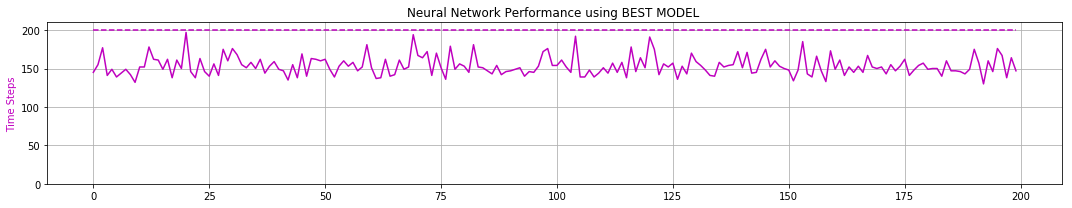

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 14
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 14: 168
REAL TIME TO GENERATE 127813 EXPERIENCES:0:00:02.724993


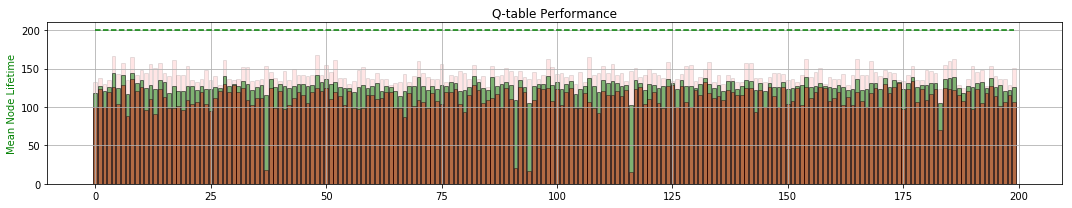

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  165.61
Validating... MEAN TIME:  146.64
Validating... MEAN TIME:  153.83
Validating... MEAN TIME:  150.375
Validating... MEAN TIME:  141.705
TRAINING TIME:0:00:34.486424


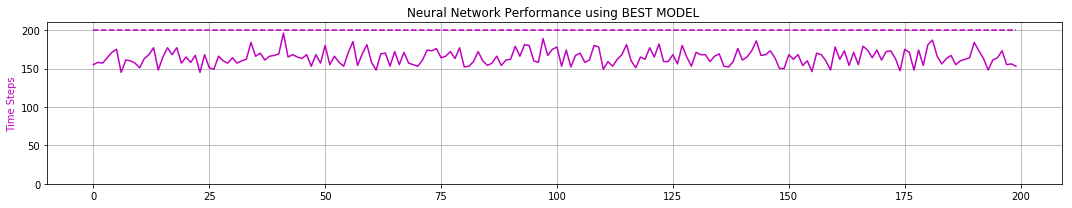

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 15
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 15: 158
REAL TIME TO GENERATE 131612 EXPERIENCES:0:00:02.789643


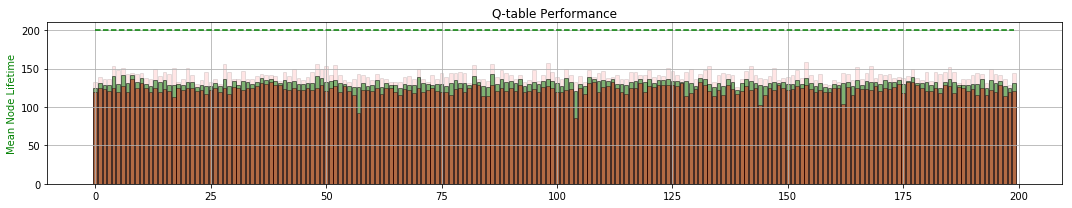

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  135.59
Validating... MEAN TIME:  134.255
Validating... MEAN TIME:  136.99
Validating... MEAN TIME:  139.645
Validating... MEAN TIME:  132.73
TRAINING TIME:0:00:35.132832


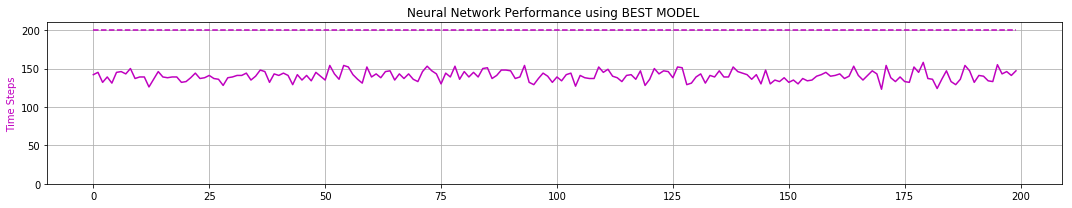

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 16
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 16: 139
REAL TIME TO GENERATE 109073 EXPERIENCES:0:00:02.465942


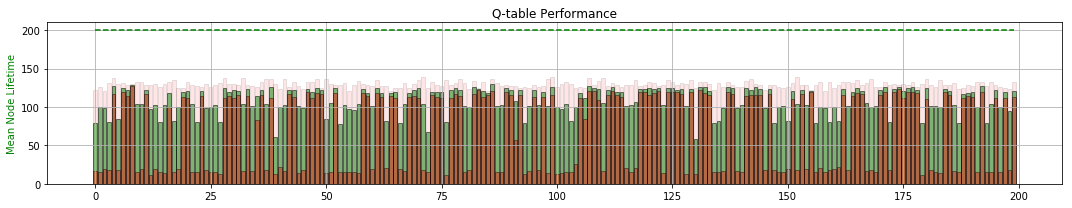

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  148.045
Validating... MEAN TIME:  162.64
Validating... MEAN TIME:  151.725
Validating... MEAN TIME:  154.885
Validating... MEAN TIME:  161.405
TRAINING TIME:0:00:34.775049


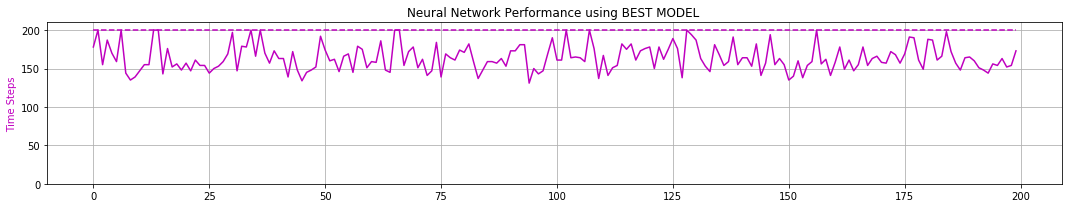

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 17
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 17: 173
REAL TIME TO GENERATE 128339 EXPERIENCES:0:00:02.738133


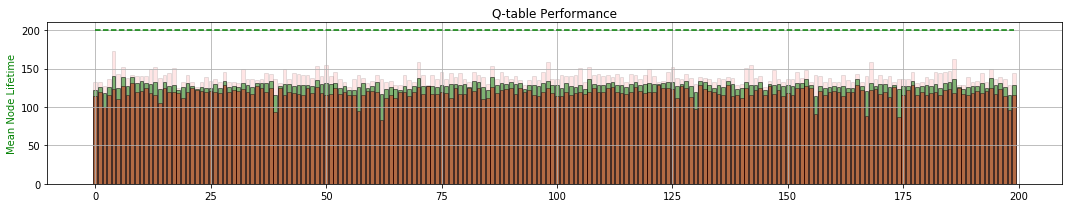

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  135.785
Validating... MEAN TIME:  145.325
Validating... MEAN TIME:  138.365
Validating... MEAN TIME:  137.805
Validating... MEAN TIME:  137.06
TRAINING TIME:0:00:34.028255


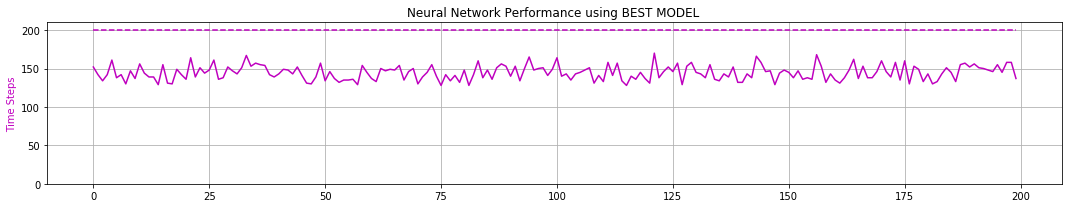

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 18
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 18: 150
REAL TIME TO GENERATE 122998 EXPERIENCES:0:00:02.655129


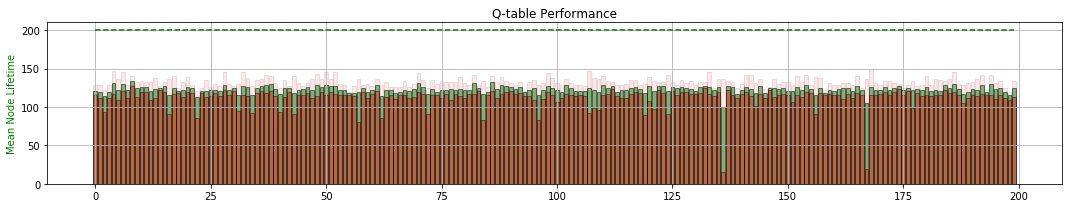

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  129.015
Validating... MEAN TIME:  130.85
Validating... MEAN TIME:  134.43
Validating... MEAN TIME:  134.09
Validating... MEAN TIME:  131.07
TRAINING TIME:0:00:30.858250


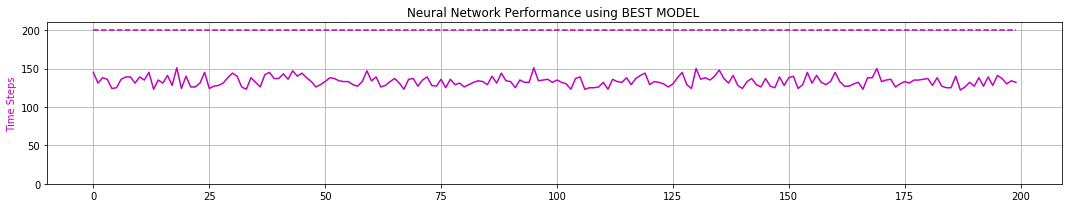

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 19
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 19: 141
REAL TIME TO GENERATE 114610 EXPERIENCES:0:00:02.584915


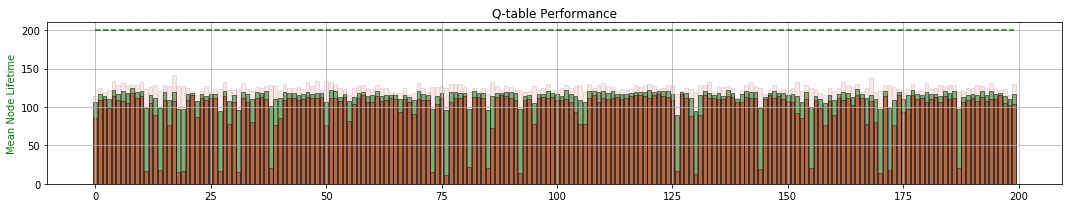

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  121.64
Validating... MEAN TIME:  124.67
Validating... MEAN TIME:  122.485
Validating... MEAN TIME:  128.42
Validating... MEAN TIME:  127.725
TRAINING TIME:0:00:29.898123


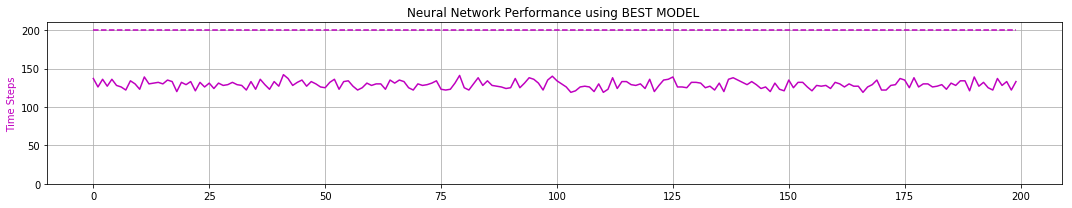

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 20
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 20: 126
REAL TIME TO GENERATE 109334 EXPERIENCES:0:00:02.503700


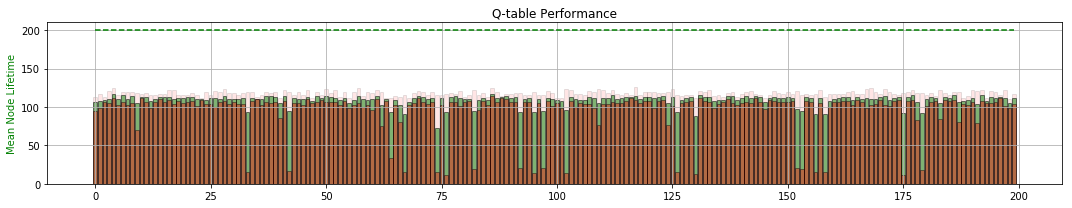

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  124.02
Validating... MEAN TIME:  118.64
Validating... MEAN TIME:  127.75
Validating... MEAN TIME:  118.715
Validating... MEAN TIME:  114.285
TRAINING TIME:0:00:28.999294


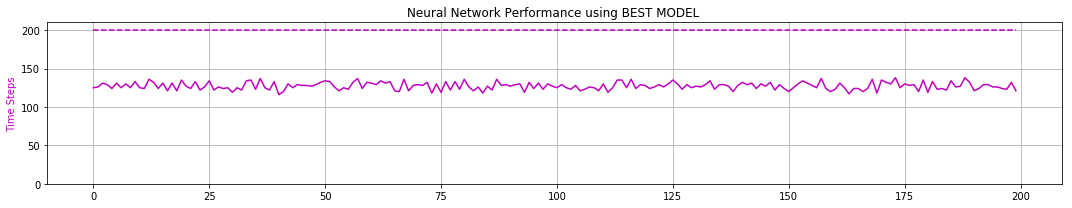

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 21
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 21: 126
REAL TIME TO GENERATE 107246 EXPERIENCES:0:00:02.460484


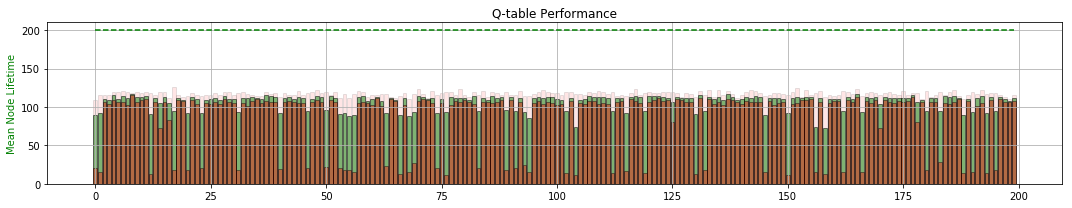

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  125.81
Validating... MEAN TIME:  124.77
Validating... MEAN TIME:  132.025
Validating... MEAN TIME:  112.07
Validating... MEAN TIME:  120.11
TRAINING TIME:0:00:28.853333


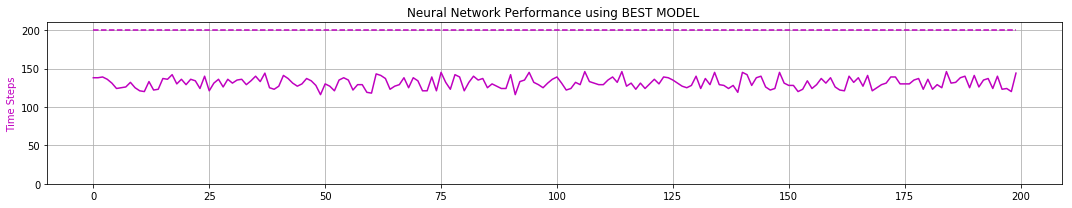

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 22
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 22: 146
REAL TIME TO GENERATE 114676 EXPERIENCES:0:00:02.565190


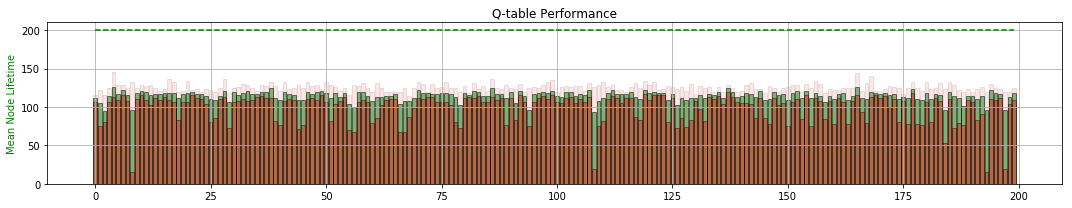

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  130.185
Validating... MEAN TIME:  124.465
Validating... MEAN TIME:  115.47
Validating... MEAN TIME:  122.285
Validating... MEAN TIME:  120.025
TRAINING TIME:0:00:28.853432


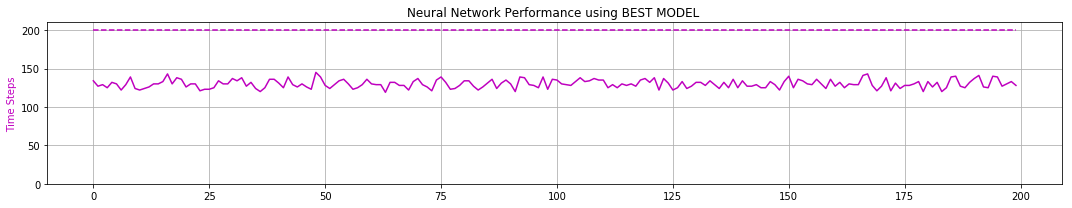

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 23
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 23: 126
REAL TIME TO GENERATE 107385 EXPERIENCES:0:00:02.473678


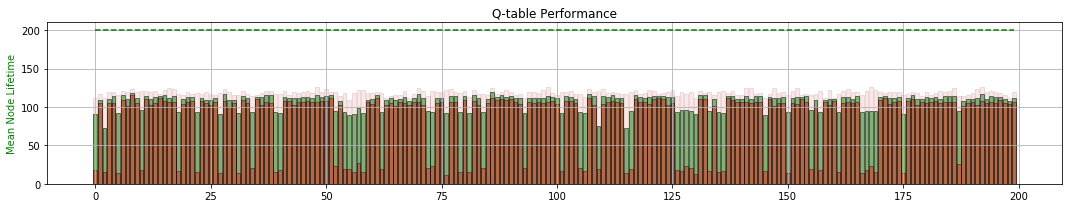

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  117.195
Validating... MEAN TIME:  124.95
Validating... MEAN TIME:  116.43
Validating... MEAN TIME:  118.585
Validating... MEAN TIME:  116.965
TRAINING TIME:0:00:27.816712


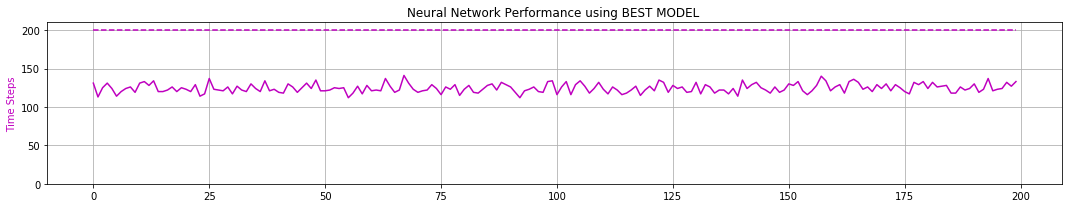

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


ITERATION # 24
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 24: 140
REAL TIME TO GENERATE 106009 EXPERIENCES:0:00:02.456156


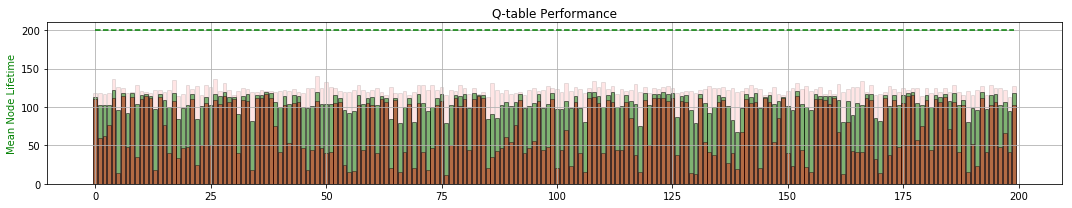

Training Neural Network for 3000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  113.34
Validating... MEAN TIME:  116.655
Validating... MEAN TIME:  116.165
Validating... MEAN TIME:  115.235
Validating... MEAN TIME:  115.365
TRAINING TIME:0:00:28.181433


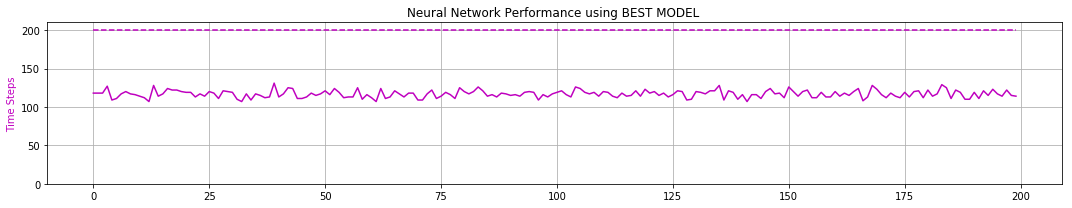

DISCRETIZING THE Q-TABLE WITH BEST MODEL...
DISCRETIZING FINISHED


In [17]:
iteration = 0
dqn = DDQN()
MODEL_FILENAME = RNDM_STRING + "_NN" + ".xpt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# Create a pool of processes
pool = mp.Pool(NO_OF_NODES)

while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()

    # Map aigym environment to each process
    args = range(NO_OF_NODES)
    result = pool.map(mp_node_run, args)
    
    node_time_rec = np.array([item[1] for item in result])
    node_exp = np.array([item[0] for item in result ])
    all_exp = np.array([item for each_node_exp in node_exp 
                                for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,10)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    
    
    #PLOT EXPERIENCES
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    #segregate experiences
    good_mem = all_exp[all_exp[:,5] == 1]
    bad_mem  = all_exp[all_exp[:,5]  < 1]
    
#     if good_mem.shape[0] < BATCH_SIZE*100:
#         dqn.good_memory = np.vstack((dqn.good_memory, good_mem))
#     else:
#         dqn.good_memory = good_mem
        
#     if bad_mem.shape[0] < BATCH_SIZE*100:
#         dqn.bad_memory = np.vstack((dqn.bad_memory, bad_mem))
#     else:
#         dqn.bad_memory = bad_mem
    
    dqn.good_memory = good_mem
    dqn.bad_memory = bad_mem
    NN_ITERATIONS = MAX_NN_ITERATIONS

    #learn
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    
    best_dqn = DDQN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()
    
    #test NN policy using BEST MODEL
    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()
        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    print("DISCRETIZING THE Q-TABLE WITH BEST MODEL...")
   
    
#     old_Q = Q_TABLE.copy()
#     %time 
    Q_TABLE = best_dqn.get_qvals(state_combinations).reshape(GRANULARITY,GRANULARITY,GRANULARITY,GRANULARITY,-1)

    #NORMALIZING Q-TABLE
#     Q_TABLE = -1 + 2.0 * (Q_TABLE-Q_TABLE.min())/(Q_TABLE.max() - Q_TABLE.min())

#     # PRINTING DIFFERENCE
#     print("DIFFERENCE:\n   MAX\t\t MIN\t\t MEAN\t\t STD")
#     diff_max   = old_Q.max() - Q_TABLE.max()
#     diff_min   = old_Q.min() - Q_TABLE.min()
#     diff_mean  = old_Q.mean() - Q_TABLE.mean()
#     diff_std   = old_Q.std() - Q_TABLE.std()
#     print("{:8.2f}\t{:8.2f}\t{:8.2f}\t{:8.2f}\t".format(diff_max, diff_min, diff_mean,diff_std))
    
    print("DISCRETIZING FINISHED")
#     print("UPDT Q: "+ str(Q_TABLE.mean()))
    np.save(Q_FILENAME,Q_TABLE)

    iteration += 1

pool.close()
pool.join()

In [18]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  3532.0
Total Serial Timesteps   :  2490579.0
Speed-up                 :  705.15
